# Import Libraries

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix


# Data Storage & Preprocessing

In [49]:
def read_data(file_path):

    df = pd.read_csv(file_path)
    df = df.rename(columns={"Time (s)": "t", "X (m/s^2)": "x", "Y (m/s^2)": "y", "Z (m/s^2)": "z"})
    return df

def label_data(df, label):

    df['activity'] = label
    return df

def preprocess_data(df, window_size):

    # Remove first and last 3 seconds
    df = df.iloc[int(3 * df.shape[0] / 30):int(-3 * df.shape[0] / 30)]
   # Apply rolling mean with window size
    df_windowed = df.rolling(window_size).mean().dropna()
    df_windowed = df_windowed.sample(frac=1).reset_index(drop=True)

    # Apply normalization to x,y,z columns only
    scaler = MinMaxScaler()
    df_windowed[['x', 'y', 'z']] = scaler.fit_transform(df_windowed[['x', 'y', 'z']]) 

    return df_windowed


kieran_walking = read_data('Accelerometer_Walking_Kieran.csv').reset_index(drop=True)
kieran_jumping = read_data('Accelerometer_Jumping_Kieran.csv').reset_index(drop=True)
amir_walking = read_data('Accelerometer_Walking_Amir.csv').reset_index(drop=True)
amir_jumping = read_data('Accelerometer_Jumping_Amir.csv').reset_index(drop=True)
jack_walking = read_data('Accelerometer_Walking_Jack.csv').reset_index(drop=True)
jack_jumping = read_data('Accelerometer_Jumping_Jack.csv').reset_index(drop=True)

allraw = pd.concat([kieran_walking, kieran_jumping, amir_walking, amir_jumping, jack_walking, jack_jumping], ignore_index=True)
allraw.to_csv('allraw.csv', index=False)

kieran_walking = label_data(kieran_walking, 0)
kieran_jumping = label_data(kieran_jumping, 1)
amir_walking = label_data(amir_walking, 0)
amir_jumping = label_data(amir_jumping, 1)
jack_walking = label_data(jack_walking, 0)
jack_jumping = label_data(jack_jumping, 1)


window_size = 500
kieran_walking_windowed = preprocess_data(kieran_walking, window_size)
kieran_jumping_windowed = preprocess_data(kieran_jumping, window_size)
amir_walking_windowed = preprocess_data(amir_walking, window_size)
amir_jumping_windowed = preprocess_data(amir_jumping, window_size)
jack_walking_windowed = preprocess_data(jack_walking, window_size)
jack_jumping_windowed = preprocess_data(jack_jumping, window_size)


df_concat = pd.concat([kieran_walking_windowed, kieran_jumping_windowed,
amir_walking_windowed, amir_jumping_windowed,
jack_walking_windowed, jack_jumping_windowed], ignore_index=True)


df_concat.to_csv('accelerometer_data.csv', index=False)

In [36]:
pd.DataFrame(df_concat)

,t,x,y,z,activity
0,77.238154,0.668843,0.944967,0.998537,0.0
1,66.570590,0.558024,0.467504,0.525588,0.0
2,133.969211,0.956258,0.849748,0.566601,0.0
3,68.841872,0.435855,0.582787,0.764278,0.0
4,26.699117,0.544536,0.023881,0.025063,0.0
...,...,...,...,...,...
142765,178.655916,0.535974,0.151821,0.057298,1.0
142766,216.238433,0.522907,0.140622,0.062230,1.0
142767,132.878162,0.284151,0.529722,0.309229,1.0
142768,330.334736,0.895895,0.994151,0.755306,1.0


# Visualization

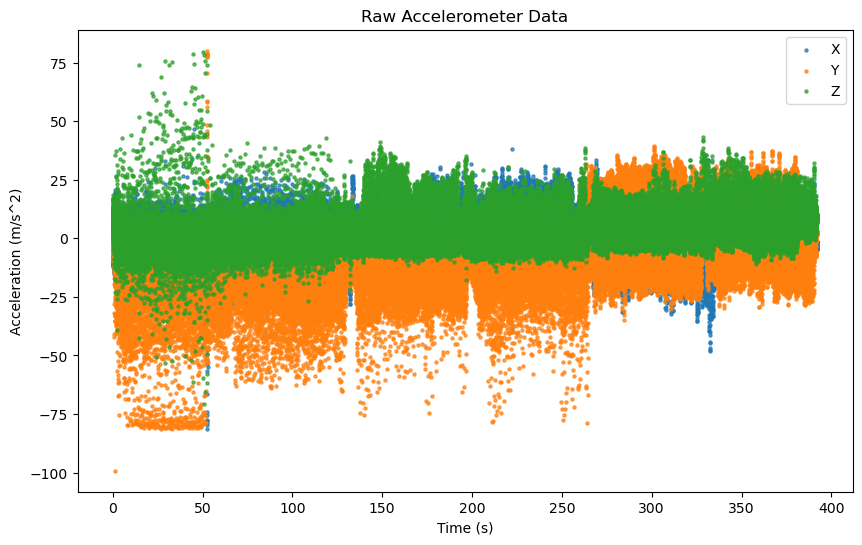

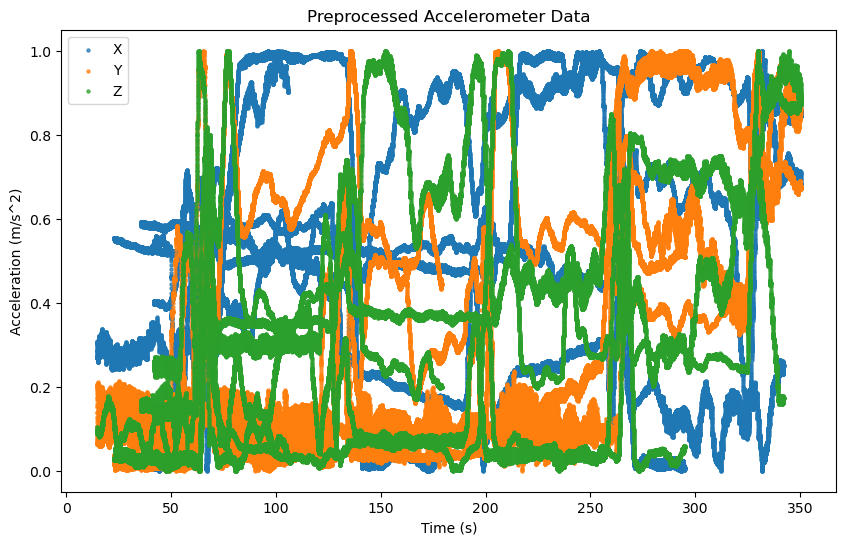

In [50]:
def plot_scatter_data(df, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['t'], df['x'], label='X', alpha=0.7, s=5)
    plt.scatter(df['t'], df['y'], label='Y', alpha=0.7, s=5)
    plt.scatter(df['t'], df['z'], label='Z', alpha=0.7, s=5)
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.legend()
    plt.title(title)
    plt.show()

# Visualize raw data
plot_scatter_data(raw_data, 'Raw Accelerometer Data')

# Visualize preprocessed data
plot_scatter_data(preprocessed_data, 'Preprocessed Accelerometer Data')

# Feature Extraction

In [30]:
def extract_features(data):
    features = []
    for window in data:
        feature_list = []
        for axis in range(1, 4):  # Iterate over x, y, and z axes
            axis_data = window[:, axis]

            # Calculate the features for each axis
            max_value = np.max(axis_data)
            min_value = np.min(axis_data)
            range_value = max_value - min_value
            mean_value = np.mean(axis_data)
            median_value = np.median(axis_data)
            variance = np.var(axis_data)
            skewness = stats.skew(axis_data)
            rms = np.sqrt(np.mean(axis_data ** 2))
            kurtosis = stats.kurtosis(axis_data)
            std_dev = np.std(axis_data)

            # Add the features to the feature list
            feature_list.extend([max_value, min_value, range_value, mean_value, median_value,
                                 variance, skewness, rms, kurtosis, std_dev])

        features.append(feature_list)

    return np.array(features)

# Load and preprocess data
window_size = 500
df = pd.read_csv('accelerometer_data.csv')
X = df[['t', 'x', 'y', 'z']].values
y = df['activity'].values
X_windowed = np.array([X[i:i+window_size, :] for i in range(0, X.shape[0]-window_size+1)])
X_features = extract_features(X_windowed)

# Save features to CSV file
feature_names = ['x_max', 'x_min', 'x_range', 'x_mean', 'x_median', 'x_variance',
                 'x_skewness', 'x_rms', 'x_kurtosis', 'x_std_dev',
                 'y_max', 'y_min', 'y_range', 'y_mean', 'y_median', 'y_variance',
                 'y_skewness', 'y_rms', 'y_kurtosis', 'y_std_dev',
                 'z_max', 'z_min', 'z_range', 'z_mean', 'z_median', 'z_variance',
                 'z_skewness', 'z_rms', 'z_kurtosis', 'z_std_dev']
df_features = pd.DataFrame(X_features, columns=feature_names)
df_features['activity'] = y[window_size-1:]
df_features.to_csv('accelerometer_features.csv', index=False)

/var/folders/wf/1bpmlk156rjfmp6t7kqqghbc0000gn/T/ipykernel_30947/4254444222.py:15: DeprecationWarning: Please use `skew` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  skewness = stats.skew(axis_data)
/var/folders/wf/1bpmlk156rjfmp6t7kqqghbc0000gn/T/ipykernel_30947/4254444222.py:17: DeprecationWarning: Please use `kurtosis` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  kurtosis = stats.kurtosis(axis_data)


In [31]:
pd.DataFrame(df_features)

,x_max,x_min,x_range,x_mean,x_median,x_variance,x_skewness,x_rms,x_kurtosis,x_std_dev,...,z_min,z_range,z_mean,z_median,z_variance,z_skewness,z_rms,z_kurtosis,z_std_dev,activity
0,0.997580,0.001096,0.996484,0.589275,0.537752,0.133903,-0.354805,0.693648,-1.234634,0.365927,...,0.001659,0.997622,0.313146,0.305915,0.052325,0.581337,0.387795,0.247912,0.228746,0.0
1,0.997580,0.001096,0.996484,0.589918,0.537752,0.134211,-0.356244,0.694417,-1.237392,0.366349,...,0.001659,0.997622,0.311967,0.305915,0.051402,0.557556,0.385649,0.210003,0.226720,0.0
2,0.997580,0.001096,0.996484,0.590780,0.537752,0.134527,-0.359464,0.695376,-1.239507,0.366779,...,0.001659,0.997622,0.311762,0.305915,0.051335,0.559915,0.385397,0.218895,0.226573,0.0
3,0.997580,0.001096,0.996484,0.590827,0.537752,0.134563,-0.359297,0.695442,-1.239696,0.366828,...,0.001659,0.997622,0.311462,0.305915,0.051228,0.562997,0.385015,0.232309,0.226335,0.0
4,0.997580,0.001096,0.996484,0.591261,0.538234,0.134522,-0.362848,0.695782,-1.236988,0.366773,...,0.001659,0.998037,0.311933,0.305915,0.051765,0.587643,0.386092,0.296779,0.227518,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142266,0.953839,0.013098,0.940740,0.445986,0.501423,0.036149,-0.535073,0.484823,-0.262762,0.190130,...,0.002103,0.962233,0.273373,0.086522,0.097050,0.918864,0.414466,-0.906632,0.311528,1.0
142267,0.953839,0.013098,0.940740,0.446652,0.501809,0.036030,-0.543226,0.485312,-0.243556,0.189815,...,0.002103,0.962233,0.272012,0.085830,0.096697,0.929531,0.413143,-0.885107,0.310961,1.0
142268,0.953839,0.013098,0.940740,0.446298,0.501809,0.036082,-0.537704,0.485040,-0.254496,0.189952,...,0.002103,0.962233,0.272555,0.086522,0.096589,0.926699,0.413371,-0.887546,0.310788,1.0
142269,0.953839,0.013098,0.940740,0.446972,0.501809,0.036460,-0.514242,0.486049,-0.242768,0.190945,...,0.002103,0.962233,0.273978,0.086823,0.096949,0.916087,0.414744,-0.909078,0.311366,1.0


# Classification & Logistic Regression

Accuracy: 0.9957829631712117
Recall: 0.9950453001132503
Cross-validation scores: [0.99589988 0.99586083 0.99586083 0.99547017 0.99515776]
Average cross-validation score: 0.9956498936149696


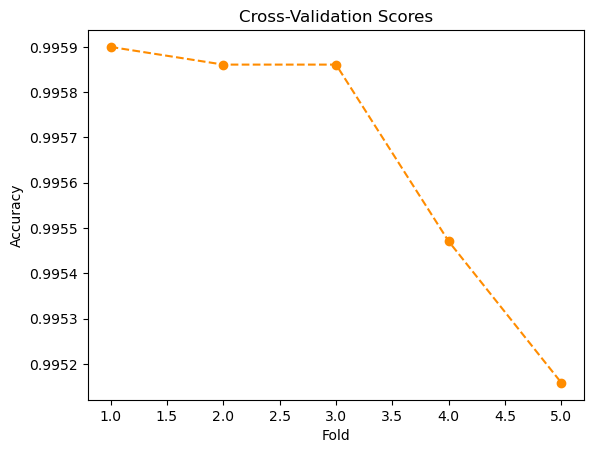

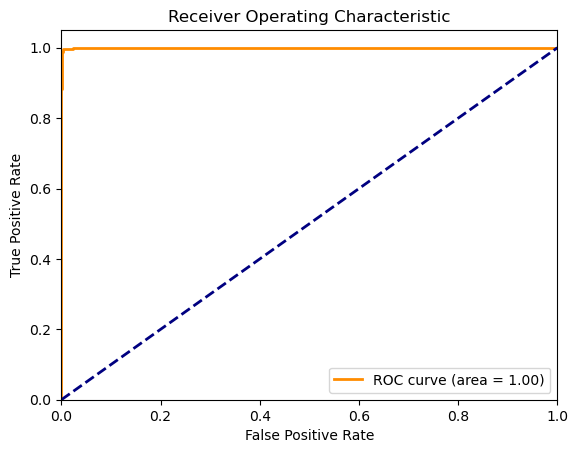

/Users/kierancosgrove/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


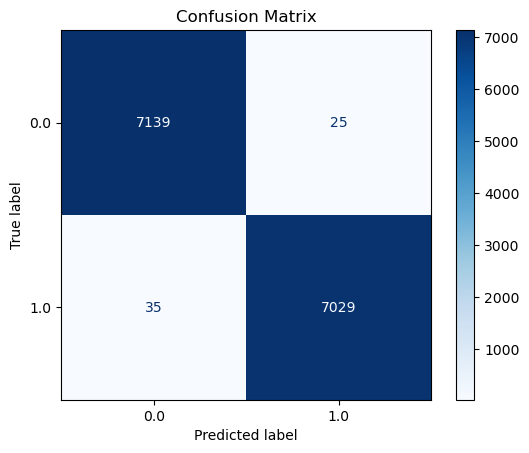

In [52]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Assuming X_features and y are already defined

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y[window_size-1:], test_size=0.1, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model with increased max_iter
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Save the trained logistic regression model
pd.to_pickle(log_reg, 'logistic_regression_model.pkl')

# Evaluate the model on the test set
y_pred = log_reg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print(f'Cross-validation scores: {cv_scores}')
print(f'Average cross-validation score: {cv_scores.mean()}')

# Plot the cross-validation scores
plt.figure()
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--', color='darkorange')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.show()

# Plot the ROC curve
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot the confusion matrix
plot_confusion_matrix(log_reg, X_test_scaled, y_test, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Learning Curve

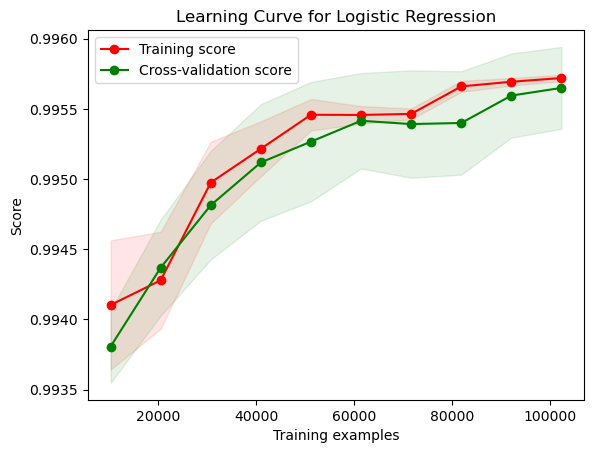

In [43]:
# Define a function to plot the learning curve
def plot_learning_curve(train_sizes, train_scores, test_scores, title):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title(title)
    plt.show()

# Calculate the learning curve
train_sizes, train_scores, test_scores = learning_curve(log_reg, X_train_scaled, y_train, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10))

# Plot the learning curve
plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning Curve for Logistic Regression')

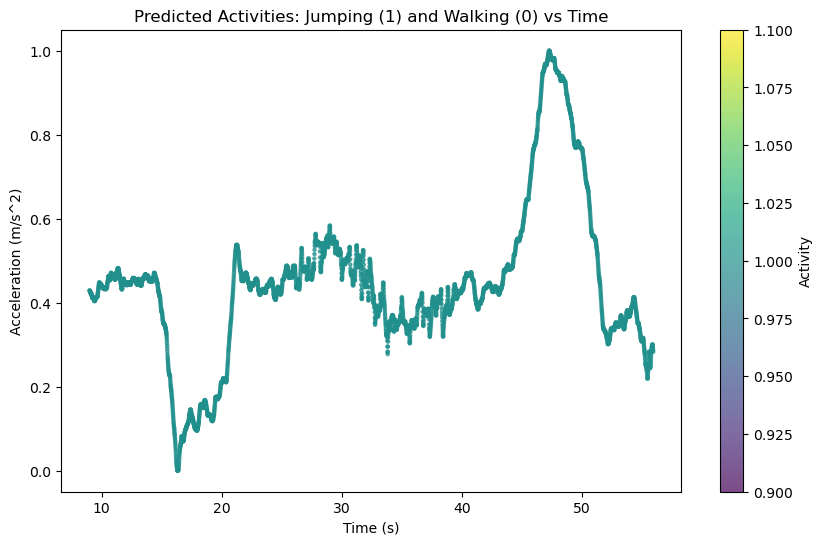

In [60]:
import os
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


# Load the trained Logistic Regression model
def load_model(model_file):
    model = pd.read_pickle(model_file)
    return model


# Predict activities for the input data
def predict_activities(input_file, output_file, model, window_size=500):
    # Read the new raw data
    df = pd.read_csv(input_file)
    
    # Rename the columns to match your input file's column names
    df = df.rename(columns={"Time (s)": "t", "Linear Acceleration x (m/s^2)": "x", "Linear Acceleration y (m/s^2)": "y", "Linear Acceleration z (m/s^2)": "z"})
    
    # Drop the last column
    df = df.drop(columns=["Absolute acceleration (m/s^2)"])

    # Preprocess the data
    df_preprocessed = preprocess_data(df, window_size)

    X = df_preprocessed[['t', 'x', 'y', 'z']].values
    X_windowed = np.array([X[i:i + window_size, :] for i in range(0, X.shape[0] - window_size + 1)])
    X_features = extract_features(X_windowed)

    # Scale the data
    scaler = StandardScaler()
    X_features_scaled = scaler.fit_transform(X_features)

    # Make predictions
    y_pred = model.predict(X_features_scaled)

    # Expand the predicted activities to match the length of the input data
    y_pred_expanded = np.repeat(y_pred, window_size)[:len(df_preprocessed)]

    # Save predictions to the output file
    output_df = pd.DataFrame({'activity': y_pred_expanded})
    output_df.to_csv(output_file, index=False)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(df_preprocessed['t'], y_pred_expanded, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Activity')
    plt.title('Predicted Activities: Jumping (1) and Walking (0) vs Time')
    plt.yticks([0, 1], ['Walking', 'Jumping'])
    plt.grid(True)

    # Display the plot
    plt.show()


# GUI functions
def browse_input_file():
    input_file_path.set(filedialog.askopenfilename(title="Select Input CSV File"))


def browse_output_file():
    output_file_path.set(filedialog.asksaveasfilename(title="Select Output CSV File", defaultextension=".csv"))


def run_prediction():
    input_file = input_file_path.get()
    if input_file:
        try:
            # Generate the output file name based on the input file name
            output_file = os.path.splitext(input_file)[0] + "_predictions.csv"
            
            predict_activities(input_file, output_file, model)
            messagebox.showinfo("Success", f"Prediction completed and saved to the output file: {output_file}")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred during prediction: {e}")
    else:
        messagebox.showerror("Error", "Please select an input file.")


# Create the main window
root = tk.Tk()
root.title("Activity Prediction App")

# Create input file frame
input_file_frame = tk.Frame(root)
input_file_frame.pack(padx=10, pady=10)

input_file_label = tk.Label(input_file_frame, text="Input CSV File:")
input_file_label.pack(side=tk.LEFT)

input_file_path = tk.StringVar()
input_file_entry = tk.Entry(input_file_frame, textvariable=input_file_path, width=50)
input_file_entry.pack(side=tk.LEFT, padx=10)

input_file_browse_button = tk.Button(input_file_frame, text="Browse", command=browse_input_file)
input_file_browse_button.pack(side=tk.LEFT)

# Create the Run Prediction button
run_button = tk.Button(root, text="Run Prediction", command=run_prediction)
run_button.pack(pady=10)

# Load the trained logistic regression model
model = load_model('logistic_regression_model.pkl')

# Run the main loop
root.mainloop()